In [53]:
from collections import defaultdict
from scipy.stats import itemfreq
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import feature
from PIL import Image as IMG
import numpy as np
import pandas as pd 
import operator
import cv2
import os 

from IPython.core.display import HTML 
from IPython.display import Image

images_path = '../data/train_jpg/'
imgs = os.listdir(images_path)

features = pd.DataFrame()
features['image'] = imgs

In [54]:
features = features[:700000]
features.shape

(700000, 1)

## 1. Is the image Very Dull

#### Feature 1 : Dullness

Dull Images may not be good for the advirtisment purposes. The analysis of prominent colors present in the images can indicate a lot about if the image is dull or not. In the following cell, I have added a code to measure the dullness score of the image which can be used as one of the feature in the model.

In [55]:
def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

Lets compute the dull score for the sample images from Avito's dataset

In [56]:
def perform_color_analysis(img, flag):
    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None

In [57]:
features['dullness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'black'))
topdull = features.sort_values('dullness', ascending = False)
topdull.head(5)

,image,dullness
411850,4bd9e6b84fb86077c77c5b6189c2a79707e743f91b5bb7...,100.0
255194,2ef93212c9260724a1d4537c0a439d8efca031a017c381...,100.0
116566,15748b7cff462642ae68f58fdc62b24bdeb7cd270ad463...,100.0
116494,15712d71fc4924db9ce45142ac0df2fcb8b29c9461e372...,100.0
255311,2efeb90449246b8629089c03bd21ec23eed3d96e5181cd...,100.0


In [58]:
features.to_csv("../data/train_image_features1.csv")

Lets plot some of the images with very high dullness

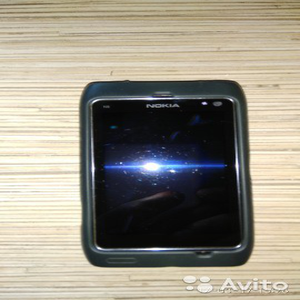

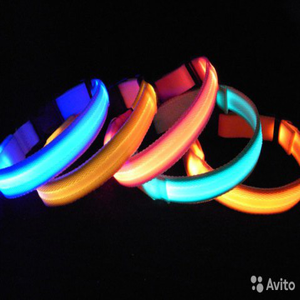

In [59]:
for j,x in topdull.head(2).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Dullness : " + str(x['dullness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

## 2. Is the Image too bright or white

#### Feature 2 : Image Whiteness

Some images can be too white or too bright which might not be good for the advertisement purposes. Using the samy type of color analysis, we can check if the images are too white.

In [60]:
features['whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
topdull = features.sort_values('whiteness', ascending = False)
topdull.head(5)

,image,dullness,whiteness
147421,1b2289ba7b3cd4cbde9d954436d20d9d2a4402851635b9...,0.0,100.0
172521,1fc335ad935b50d4916ee26d0f82107ac19e898550e945...,0.0,100.0
522177,60346e98708ed5fd25f1285175416903b9bb5f56f62613...,0.0,100.0
172493,1fc1e2cec2a8c3bad593ba5f0f68a658afa8529a00b709...,0.0,100.0
18776,037c1057ad2e4e9834c52b3a0f35bfadafa5916ee39b22...,0.0,100.0


Lets plot some of the images having high whiteness score

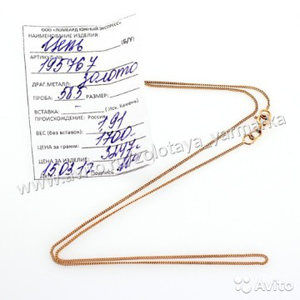

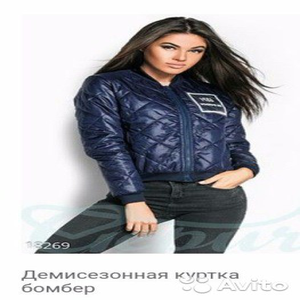

In [61]:
for j,x in topdull.head(2).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Whiteness : " + str(x['whiteness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

## 3. Uniform Images (with no pixel variations)

#### Feature 3 - Average Pixel Width (using edge detection)

Some images may contain no pixel variation and are entirely uniform. Average Pixel Width is a measure which indicates the amount of edges present in the image. If this number comes out to be very low, then the image is most likely a uniform image and may not represent right content.

To compute this measure, I am using skimage's Canny Detection



In [62]:
# im1 = IMG.open(images_path+'0000384bc4b1aa7c9dca81f2f56f72a9945728d4afdf662e21884884ed4d0cce.jpg')
# im2 = im1.convert(mode='L')
# im = np.asarray(im2)

# edges1 = feature.canny(im, sigma=1)
# edges2 = feature.canny(im, sigma=3)

# # display results
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

# ax1.imshow(im, cmap=plt.cm.gray)
# ax1.axis('off')
# ax1.set_title('noisy image', fontsize=20)

# ax2.imshow(edges1, cmap=plt.cm.gray)
# ax2.axis('off')
# ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

# ax3.imshow(edges2, cmap=plt.cm.gray)
# ax3.axis('off')
# ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

# fig.tight_layout()

# plt.show()

In [ ]:
def average_pixel_width(img):
    path = images_path + img 
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [ ]:
features['average_pixel_width'] = features['image'].apply(average_pixel_width)
tempdf = features.sort_values('average_pixel_width').head()
tempdf 

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


Lets plot some images having very low average pixel width

In [ ]:
for j,x in tempdf.head(6).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Average Pixel Width : " + str(x['average_pixel_width']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

Above images are most likely nosie and have low average pixel width values.

## 4. What are the key colors used in the image ?

Colors used in the images play a significant role in garnering the attraction from users. Additional features related to colors such as Dominant and Average colors can be created.

#### Feature 4.1 - Dominant Color

In [ ]:
def get_dominant_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    arr = np.float32(img)
    pixels = arr.reshape((-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
    return dominant_color

features['dominant_color'] = features['image'].apply(get_dominant_color)
features.head(10)

Lets split the dominant color's RGB values to separate features

- Feature 4.1.1 dominant_red value
- Feature 4.1.2 dominant_green value
- Feature 4.1.3 dominant_blue value

In [ ]:
features['dominant_red'] = features['dominant_color'].apply(lambda x: x[0]) / 255
features['dominant_green'] = features['dominant_color'].apply(lambda x: x[1]) / 255
features['dominant_blue'] = features['dominant_color'].apply(lambda x: x[2]) / 255
features[['dominant_red', 'dominant_green', 'dominant_blue']].head(5)

#### Feature 4.2 Average Color

In [ ]:
def get_average_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    average_color = [img[:, :, i].mean() for i in range(img.shape[-1])]
    return average_color

features['average_color'] = features['image'].apply(get_average_color)
features.head(10)

In [ ]:
features['average_red'] = features['average_color'].apply(lambda x: x[0]) / 255
features['average_green'] = features['average_color'].apply(lambda x: x[1]) / 255
features['average_blue'] = features['average_color'].apply(lambda x: x[2]) / 255
features[['average_red', 'average_green', 'average_blue']].head(5)

## 5. Dimensions of the Image

Too Big Images or Too Small Images might not be very good for generating good attraction. Users may skip viewing a very large or very small sized image. Hence for advertisers it is important to set precise dimensions and size of the image. Hence we can create additional features.

- Image width
- Image height
- Image size

In [23]:
def getSize(filename):
    filename = images_path + filename
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    filename = images_path + filename
    img_size = IMG.open(filename).size
    return img_size 

In [24]:
features['image_size'] = features['image'].apply(getSize)
features['temp_size'] = features['image'].apply(getDimensions)
features['width'] = features['temp_size'].apply(lambda x : x[0])
features['height'] = features['temp_size'].apply(lambda x : x[1])
features = features.drop(['temp_size', 'average_color', 'dominant_color'], axis=1)
features.head()

,image,dullness,whiteness,average_pixel_width,dominant_red,dominant_green,dominant_blue,average_red,average_green,average_blue,image_size,width,height
0,00000acce78ccf00d3ca0c550cae60fb319d45861444b3...,0.0,0.0,1.814236,0.654902,0.686275,0.694118,0.449893,0.467398,0.465299,29625,480,360
1,00001d464b8eb4f0f90b13b9194dc214c492cbe0c484fa...,0.0,0.0,4.658951,0.121569,0.121569,0.121569,0.206053,0.226547,0.249294,51324,540,360
2,00002821738c1efaa7e73310f7a6e34d34ada6c68e0800...,0.0,0.0,1.866574,0.164706,0.168627,0.180392,0.312802,0.331120,0.346442,34616,478,360
3,00002f9ed7909130971b635ba54d3c5b3b96ba9349af2d...,0.0,0.0,5.406250,0.647059,0.654902,0.650980,0.492702,0.483834,0.469887,56700,360,480
4,0000384bc4b1aa7c9dca81f2f56f72a9945728d4afdf66...,0.0,0.0,1.917245,0.356863,0.427451,0.450980,0.420231,0.521835,0.550403,46903,480,360


## 6. Is the image too Blurry

#### Feature 6 - Image Blurrness

To measure the image blurrness, I refered to the following paper: "Diatom Autofocusing in Brightfield Microscopy: A Comparative Study".

In this paper the author Pech-Pacheco et al. has provided variance of the Laplacian Filter which can be used to measure if the image blurryness score.

In this technique, the single channel of an image is convolved with the the laplacian filter. If the specified value is less than a threshold value, then image is blurry otherwise not.

- Paper Link : http://optica.csic.es/papers/icpr2k.pdf
- Reference : https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

In [25]:
def get_blurrness_score(image):
    path =  images_path + image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [26]:
features['blurrness'] = features['image'].apply(get_blurrness_score)
features[['image','blurrness']].head(5)

,image,blurrness
0,00000acce78ccf00d3ca0c550cae60fb319d45861444b3...,284.000979
1,00001d464b8eb4f0f90b13b9194dc214c492cbe0c484fa...,462.877615
2,00002821738c1efaa7e73310f7a6e34d34ada6c68e0800...,319.289806
3,00002f9ed7909130971b635ba54d3c5b3b96ba9349af2d...,607.338787
4,0000384bc4b1aa7c9dca81f2f56f72a9945728d4afdf66...,294.951346


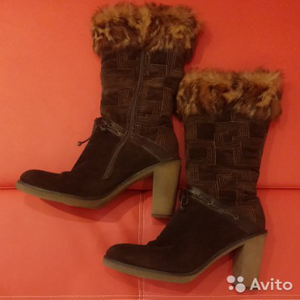

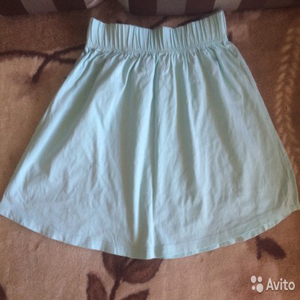

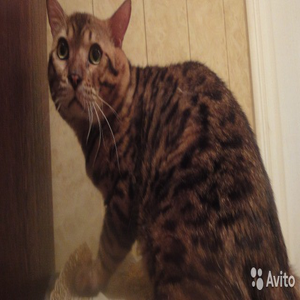

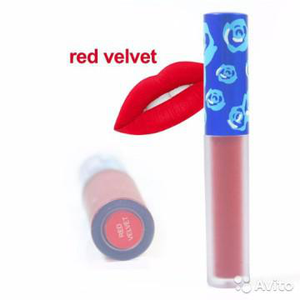

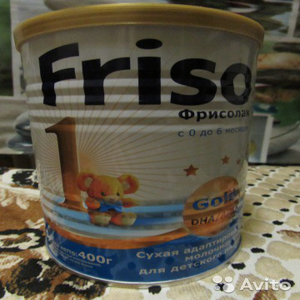

In [27]:
tempdf = features.sort_values('blurrness')
for y,x in tempdf.head(5).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Blurrness : " + str(x['blurrness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

## Other Ideas about features from Image

- No of objects detected
- Total Number of Color Present
- No. of shapes detected
- Amount of Text Present in the image

Other great kernels on Image Feature Extraction:

- https://www.kaggle.com/wesamelshamy/ad-image-recognition-and-quality-scoring by wesamelshamy
- https://www.kaggle.com/peterhurford/image-feature-engineering by peterhurford